In [13]:
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from astropy import modeling
set_matplotlib_formats('retina')

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

from scipy import stats
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

from inspect import signature

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import  TensorDataset, DataLoader
from torchvision.utils import save_image
import os
from os import listdir
from os.path import isfile, join

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, roc_curve

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

pd.options.display.float_format = '{:.2f}'.format

# data=pd.read_csv("./data_1004.csv")
# data=pd.read_csv("./data1201.csv")
data=pd.read_csv("./data2100205.csv")

columns = data.iloc[:,2:-19].columns
columns =columns.drop(['pleura_tb', 'pleura_bac','blood_positive', 'blood_obscure', 'cancer'])
float_column=data[columns].select_dtypes(include=['float']).columns
object_column = data[columns].select_dtypes(include=['object']).columns
not_object = ['D-dimer', 'BNP', 'procalcitonin', 'ANA titer','ANA 1:40','ionized calcium','E-ANC_blood']

data[not_object[0]] = data[not_object[0]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[1]] = data[not_object[1]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[2]] = data[not_object[2]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[5]] = data[not_object[5]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)

def floating(x):
    try:
        value = float(x)
    except ValueError :
        value = np.nan
    return value

data[not_object[6]] = data[not_object[6]].replace("\-","",regex=True).apply(floating).astype(float)


reallist = float_column.tolist()+['D-dimer', 'BNP', 'procalcitonin','ionized calcium','E-ANC_blood']


data.loc[data['ph_pleural fluid'].isna(), 'ph_pleural fluid'] = data.loc[data['ph_pleural fluid'].isna(), 'pH_pleural fluid(Qn) ']
count_label = pd.DataFrame(data.count()/len(data))

list_04 = ['ADA_pleural fluid', 'LD_pleural fluid', 'albumin_pleural fluid', 'ph_pleural fluid', 'Total protein_pleural fluid', 'Glucose_pleural fluid',
'Total amylase_pleural fluid', 'Creatinine', 'AST(SGOT)', 'Alkaline phosphatase', 'total bilirubin', 'glucose', 'Albumin', 'BUN',
'Total protein', 'LD', 'ALT(SGPT)', 'r-GT', 'CRP', 'D-dimer', 'BNP', 'procalcitonin', 'total calcium', 'sodium', 'chloride', 'potassium', 'phosphorus', 'Hb_blood',
'RDW_blood', 'WBC_blood', 'MCHC_blood', 'MCV_blood', 'PDW_blood', 'Hct_blood', 'E-ANC_blood', 'MCH_blood', 'RBC_blood', 'MPV_blood', 'Platelet_blood', "Histiocyte (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Neutrophil (Qn)[Cytospin,Wright's stain],Pleural fluid", "RBC (Qn)[Cytospin,Wright's stain],Pleural fluid", "Eosinophil (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Nucleated cells (Qn)[Cytospin,Wright's stain],Pleural fluid", "Lymphocyte (Qn)[Cytospin,Wright's stain],Pleural fluid", "Mesothelial cell (Qn)[Cytospin,Wright's stain],Pleural fluid"
          ]

xlist =dict()

for i in range(len(list_04)):
    xlist.update({data[list_04[i]].name: stats.mode(data[list_04[i]]).mode.item()})

for i in range(len(list_04)):
    data[list_04[i]] = data[list_04[i]].replace(np.nan, xlist[list_04[i]])

data.loc[data['pleura_bac']>0,'Labeling']=3

data.loc[((data['Labeling'].isin([3,17,"3","17"]))& (data['제외']!=1)),'new_label']="bacterial"
data.loc[((data['Labeling'].isin([1,"1"]))& (data['제외']!=1)),'new_label']="tuberculosis"
data.loc[((data['Labeling'].isin([2,"2"]))& (data['제외']!=1)),'new_label']="malignancy"
data.loc[((data['Labeling'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'new_label']="volume"
data.loc[((data['Labeling'].isin([7,10,14,19,25,29,30,"7","10","14","19","25","29","30"]))
          & (data['제외']!=1)),'new_label']="other"
data.loc[((data['Labeling'].isin([8,16,24,23,20,21,27,28,"8","16","24","23","20","21","27","28"]))
          & (data['제외']!=1)),'new_label']="other"
data.loc[((data['Labeling'].isin([9,15,"9","15"]))& (data['제외']!=1))
         ,'new_label']="other"

data.loc[((data['Labeling'].isin([3,17,"3","17"]))& (data['제외']!=1)),'new_int']=0
data.loc[((data['Labeling'].isin([1,"1"]))& (data['제외']!=1)),'new_int']=1
data.loc[((data['Labeling'].isin([2,"2"]))& (data['제외']!=1)),'new_int']=2
data.loc[((data['Labeling'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'new_int']=3
data.loc[((data['Labeling'].isin([7,10,14,19,25,29,30,"7","10","14","19","25","29","30"]))
          & (data['제외']!=1)),'new_int']=4
data.loc[((data['Labeling'].isin([8,16,24,23,20,21,27,28,"8","16","24","23","20","21","27","28"]))
          & (data['제외']!=1)),'new_int']=4
data.loc[((data['Labeling'].isin([9,15,"9","15"]))& (data['제외']!=1))
         ,'new_int']=4
data.loc[((data['new_int'].isna())& (data['제외']!=1))
         ,'new_int']=4

### test set process

data.loc[((data['final'].isin([3,17,"3","17"]))& (data['제외']!=1)),'final_label']="bacterial"
data.loc[((data['final'].isin([1,"1"]))& (data['제외']!=1)),'final_label']="tuberculosis"
data.loc[((data['final'].isin([2,"2"]))& (data['제외']!=1)),'final_label']="malignancy"
data.loc[((data['final'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'final_label']="volume"
data.loc[((data['final'].isin([7,10,14,19,25,29,30,35,36,"7","10","14","19","25","29","30","35","36"]))
          & (data['제외']!=1)),'final_label']="other"
data.loc[((data['final'].isin([8,16,24,23,20,21,27,28,31,32,"8","16","24","23","20","21","27","28","31","32"]))
          & (data['제외']!=1)),'final_label']="other"
data.loc[((data['final'].isin([9,15,33,34,"9","15","33","34"]))& (data['제외']!=1))
         ,'final_label']="other"

data.loc[((data['final'].isin([3,17,"3","17"]))& (data['제외']!=1)),'final_int']=0
data.loc[((data['final'].isin([1,"1"]))& (data['제외']!=1)),'final_int']=1
data.loc[((data['final'].isin([2,"2"]))& (data['제외']!=1)),'final_int']=2
data.loc[((data['final'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'final_int']=3
data.loc[((data['final'].isin([7,10,14,19,25,29,30,35,36,"7","10","14","19","25","29","30","35","36"]))
          & (data['제외']!=1)),'final_int']=4
data.loc[((data['final'].isin([8,16,24,23,20,21,27,28,31,32,"8","16","24","23","20","21","27","28","31","32"]))
          & (data['제외']!=1)),'final_int']=4
data.loc[((data['final'].isin([9,15,33,34,"9","15","33","34"]))& (data['제외']!=1))
         ,'final_int']=4

data['LD_ratio'] = data['LD_pleural fluid']/data['LD']>=0.6
data['LD_raw'] = data['LD_pleural fluid']>= 250*2/3
data['PF_ratio'] = data['Total protein_pleural fluid']/data['Total protein']>=0.6


data['sum_pleural'] = data['LD_ratio'].replace(True, 1).replace(False,0) +data['LD_raw'].replace(True, 1).replace(False,0)+data['PF_ratio'].replace(True, 1).replace(False,0)

data['exudate']= data['sum_pleural']>=1


data['low_pH']=data['ph_pleural fluid']<7.2
data['low_glu']=data['Glucose_pleural fluid']<61
data['high_LDH']=data['LD_pleural fluid']>1000

data['score']=data['low_pH'].replace(True, 1).replace(False,0)+data['low_glu'].replace(True, 1).replace(False,0)+data['high_LDH'].replace(True, 1).replace(False,0)

data['complicated_pleural_effusion']=data['score']>2

data['might_Tb']= data['ADA_pleural fluid']>50
data['lymph_dominant'] = data["Lymphocyte (Qn)[Cytospin,Wright's stain],Pleural fluid"]/data["Neutrophil (Qn)[Cytospin,Wright's stain],Pleural fluid"]>0.75
data.loc[(data['lymph_dominant']==True) & (data['might_Tb']==True),'Tuberculosis']=1


### preprocessing
scaling, transformation, rescaling

In [3]:
data['trans_label']=data['final_label']
data.loc[data['Tuberculosis']==True,'trans_label']='rule_tuberculosis'
data.loc[(data['Tuberculosis']==True)&
         (data['final_label']!='tuberculosis'),'trans_label']='not_tuberculosis'
data['trans_int']=data['final_int']
data.loc[data['Tuberculosis']==True,'trans_int']=5
data.loc[(data['Tuberculosis']==True)&
         (data['final_label']!='tuberculosis'),'trans_int']=7

data['trans_label2']=data['final_label']
data.loc[data['complicated_pleural_effusion']==True,'trans_label2']='rule_complicated_effusion'
data.loc[(data['complicated_pleural_effusion']==True)&
         (data['final_label']!='bacterial'),'trans_label2']='not_bacteria'
data['trans_int2']=data['final_int']
data.loc[data['complicated_pleural_effusion']==True,'trans_int2']=6
data.loc[(data['complicated_pleural_effusion']==True)&
         (data['final_label']!='bacterial'),'trans_int2']=8

In [7]:
data = data.loc[data['제외']!=1]

#list 08로 먼저 시도해보자 
training = data[list_04+['new_label']+['new_int']]
training_only = training.loc[training['new_label'].isna()==False]
col_name  = training.columns.difference(["new_label",'new_int'])

# training[col_name]

range_lower = 0.05
range_upper = 0.95
outcome_quantile = training[col_name].quantile([range_lower, range_upper])

testset = data.loc[data['final_label'].isna()==False]
#testset = testset.loc[testset['final_label']!="other"]


testset_only = testset[list_04+['final_label','final_int','trans_label','trans_int',
                               'trans_label2','trans_int2']]

for i in col_name:
    testset_only.loc[(testset_only[i]<=outcome_quantile[i][range_lower]),i]=\
        outcome_quantile[i][range_lower]

    testset_only.loc[(testset_only[i]>=outcome_quantile[i][range_upper]),i]=\
        outcome_quantile[i][range_upper]

scaler01 = MinMaxScaler(feature_range=(0.01,1))
scaler01 = scaler01.fit(testset_only[col_name])
testset_only[col_name] = scaler01.transform(testset_only[col_name])

test_X = torch.tensor(testset_only[col_name].to_numpy(), dtype= torch.float32)
test_Y = torch.tensor(testset_only["final_int"].to_numpy(), dtype= torch.float32)
valid_test_Y = testset_only[['final_label','final_int','trans_label','trans_int','trans_label2','trans_int2']]
valid_test_Y = valid_test_Y.reset_index(drop=True)

In [9]:
from contrast import small_encoder, added_on_model, parse_option
from losses import SupConLoss
import torch.backends.cudnn as cudnn

import sys
sys.argv=['']
import os
import argparse
import time
import math
import tensorboard_logger as tb_logger
from util import AverageMeter
from util import adjust_learning_rate, warmup_learning_rate, accuracy
from util import set_optimizer, save_model

try:
    import apex
    from apex import amp, optimizers
except ImportError:
    pass

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
opt = parse_option()
dimension=20
input_len = 46
opt.model_path = './save/{}_{}_models'.format("effu0502_weighted", dimension)
layer_list = [[128,256,128,32],
         [256,512,128,64],
          [256,256,256,256],
         [512,512,512,512],
         [1024,1024,1024]]

loaded_model = torch.load(opt.model_path+"/model_[128, 256, 128, 32]_loss_6.250.pth")

model = small_encoder(input_len, [128, 256, 128, 32], dimension)
model.load_state_dict(loaded_model["model"])
model = model.cuda()
model = model.eval()

for param in model.parameters():
    param.requires_grad = False

### UMAP visualization

In [15]:
from umap import UMAP

umap = UMAP(random_state=0, n_neighbors = 50)
test_X = test_X.cuda()

dr = umap.fit_transform(model(test_X).cpu().numpy())

umap_l = pd.concat([pd.DataFrame(dr),valid_test_Y], axis=1)
umap_l = umap_l.rename(columns={0:"x", 1:"y"})

In [16]:
colorlist = dict(malignancy=sns.color_palette("Accent",9)[2],
                        volume=sns.color_palette("Accent",9)[4],
                        tuberculosis = sns.color_palette("Accent",9)[5],
                       bacterial = sns.color_palette("Accent",9)[0],
                       other= sns.color_palette("Accent",9)[3],
                       rule_tuberculosis = "#7987FA",
                       not_tuberculosis = "#2F4854",
                       rule_complicated_effusion="#2878EB",
                       not_bacteria = "#3B3A2A")
name = ['other','malignancy','volume','tuberculosis','bacterial']

In [17]:
print("rule based tuberculosis sensitivity")
print(len(testset.loc[(testset['final_label']=='tuberculosis')&
                (testset['Tuberculosis']==1)])/len(testset.loc[testset['final_label']=='tuberculosis']))

print("rule based tuberculosis specificity")
print(len(testset.loc[(testset['final_label']!='tuberculosis')&
                (testset['Tuberculosis']!=1)])/len(testset.loc[testset['final_label']!='tuberculosis']))

rule based tuberculosis sensitivity
0.7452830188679245
rule based tuberculosis specificity
0.9310924369747899


In [1]:
fig7, f7_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f7_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f7_axs[1:, 1]:
    ax.remove()
for ax in f7_axs[1:, 0]:
    ax.remove()
    
axbig = fig7.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig7.tight_layout()
for idx, etiology in enumerate(name):
    axbig.scatter(x=umap_l.loc[umap_l['final_label']==etiology,"x"].values,
               y=umap_l.loc[umap_l['final_label']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('UMAP1')
    axbig.set_ylabel('UMAP2')
    for j in range(5):
        if j<2:
            f7_axs[0,j].scatter(x=umap_l.loc[umap_l['final_label']==etiology,"x"].values,
                                y=umap_l.loc[umap_l['final_label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f7_axs[0,j].set_xticks([])
            f7_axs[0,j].set_yticks([])
            f7_axs[0,j].set_xlabel('')
            f7_axs[0,j].set_ylabel('')
            if idx==j:
                f7_axs[0,j].set_title(f'{etiology}')
            f7_axs[0,j].spines['top'].set_visible(False)
            f7_axs[0,j].spines['right'].set_visible(False)
            f7_axs[0,j].spines['left'].set_visible(False)
            f7_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f7_axs[j-2,2].scatter(x=umap_l.loc[umap_l['final_label']==etiology,"x"].values,
                                y=umap_l.loc[umap_l['final_label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f7_axs[j-2,2].set_xticks([])
            f7_axs[j-2,2].set_yticks([])
            f7_axs[j-2,2].set_xlabel('')
            f7_axs[j-2,2].set_ylabel('')
            if idx==j:
                f7_axs[j-2,2].set_title(f'{etiology}')
            f7_axs[j-2,2].spines['left'].set_visible(False)
            f7_axs[j-2,2].spines['right'].set_visible(False)
            f7_axs[j-2,2].spines['bottom'].set_visible(False)
            f7_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
# axbig.spines['bottom'].set_visible(False)
# axbig.spines['left'].set_visible(False)
axbig.spines['top'].set_visible(False)


fig7.tight_layout()
fig7.suptitle("UMAP embedding of contrast model", fontsize=16)
fig7.subplots_adjust(top=0.92)
fig7.savefig("./figures/extraval_umap_new 300.png", dpi=300)

NameError: name 'plt' is not defined

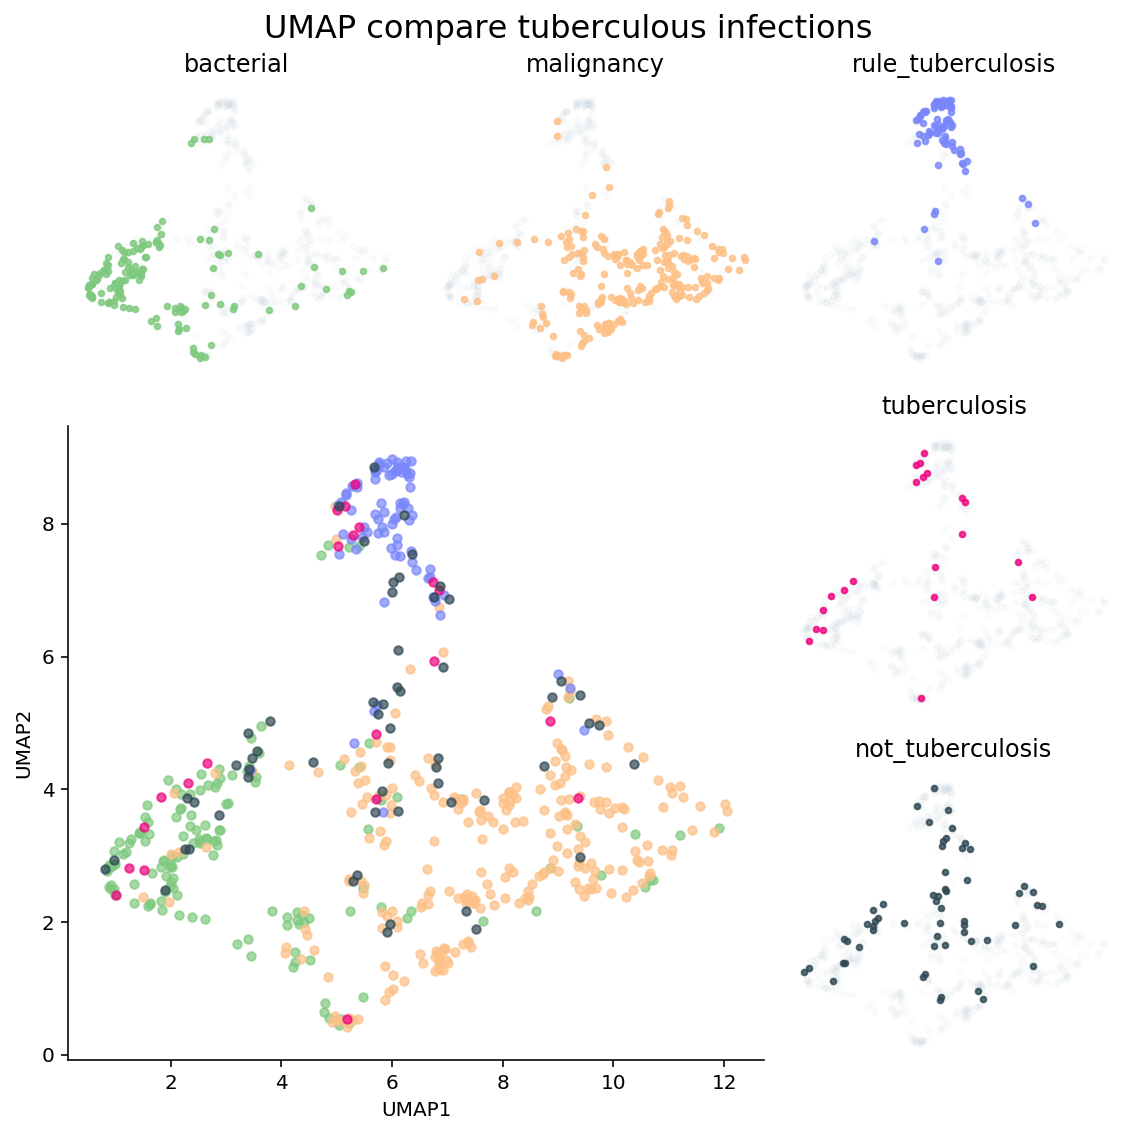

In [357]:
tb_related = ['bacterial', 'malignancy','rule_tuberculosis','tuberculosis','not_tuberculosis',]
fig8, f8_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f8_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f8_axs[1:, 1]:
    ax.remove()
for ax in f8_axs[1:, 0]:
    ax.remove()
    
axbig = fig8.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig8.tight_layout()
for idx, etiology in enumerate(tb_related):
    axbig.scatter(x=umap_l.loc[umap_l['trans_label']==etiology,"x"].values,
               y=umap_l.loc[umap_l['trans_label']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('UMAP1')
    axbig.set_ylabel('UMAP2')
    for j in range(5):
        if j<2:
            f8_axs[0,j].scatter(x=umap_l.loc[umap_l['trans_label']==etiology,"x"].values,
                                y=umap_l.loc[umap_l['trans_label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f8_axs[0,j].set_xticks([])
            f8_axs[0,j].set_yticks([])
            f8_axs[0,j].set_xlabel('')
            f8_axs[0,j].set_ylabel('')
            if idx==j:
                f8_axs[0,j].set_title(f'{etiology}')
            f8_axs[0,j].spines['top'].set_visible(False)
            f8_axs[0,j].spines['right'].set_visible(False)
            f8_axs[0,j].spines['left'].set_visible(False)
            f8_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f8_axs[j-2,2].scatter(x=umap_l.loc[umap_l['trans_label']==etiology,"x"].values,
                                y=umap_l.loc[umap_l['trans_label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f8_axs[j-2,2].set_xticks([])
            f8_axs[j-2,2].set_yticks([])
            f8_axs[j-2,2].set_xlabel('')
            f8_axs[j-2,2].set_ylabel('')
            if idx==j:
                f8_axs[j-2,2].set_title(f'{etiology}')
            f8_axs[j-2,2].spines['left'].set_visible(False)
            f8_axs[j-2,2].spines['right'].set_visible(False)
            f8_axs[j-2,2].spines['bottom'].set_visible(False)
            f8_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
# axbig.spines['bottom'].set_visible(False)
# axbig.spines['left'].set_visible(False)
axbig.spines['top'].set_visible(False)

fig8.tight_layout()
fig8.suptitle("UMAP compare tuberculous infections", fontsize=16)
fig8.subplots_adjust(top=0.92)
fig8.savefig("./figures/extraval_umap_new_tb 300.png", dpi=300)

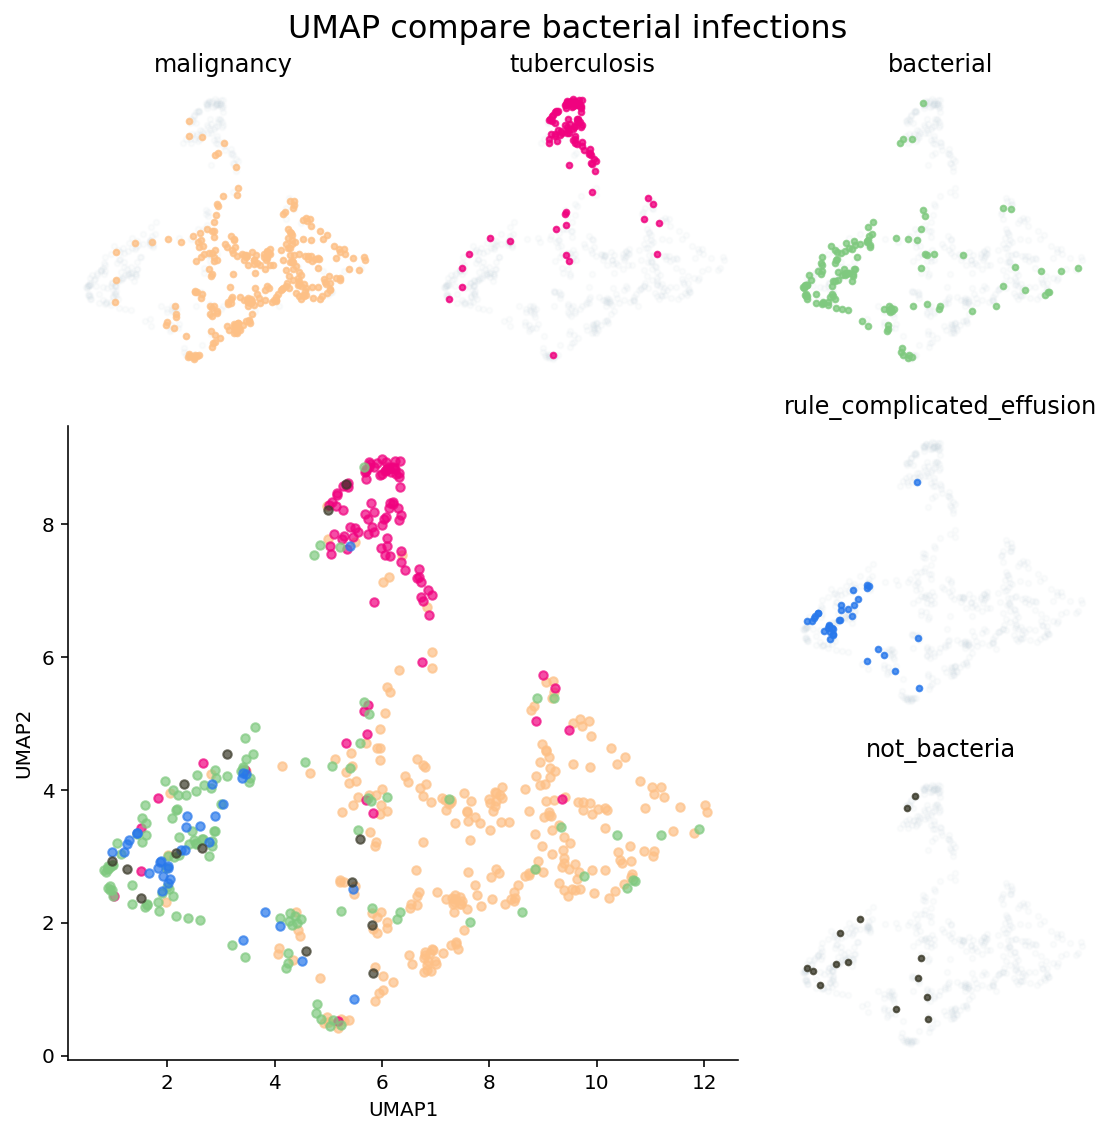

In [358]:
bacteria_related = ['malignancy','tuberculosis','bacterial','rule_complicated_effusion','not_bacteria']
fig9, f9_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f9_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f9_axs[1:, 1]:
    ax.remove()
for ax in f9_axs[1:, 0]:
    ax.remove()
    
axbig = fig9.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig9.tight_layout()
for idx, etiology in enumerate(bacteria_related):
    axbig.scatter(x=umap_l.loc[umap_l['trans_label2']==etiology,"x"].values,
               y=umap_l.loc[umap_l['trans_label2']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('UMAP1')
    axbig.set_ylabel('UMAP2')
    for j in range(5):
        if j<2:
            f9_axs[0,j].scatter(x=umap_l.loc[umap_l['trans_label2']==etiology,"x"].values,
                                y=umap_l.loc[umap_l['trans_label2']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f9_axs[0,j].set_xticks([])
            f9_axs[0,j].set_yticks([])
            f9_axs[0,j].set_xlabel('')
            f9_axs[0,j].set_ylabel('')
            if idx==j:
                f9_axs[0,j].set_title(f'{etiology}')
            f9_axs[0,j].spines['top'].set_visible(False)
            f9_axs[0,j].spines['right'].set_visible(False)
            f9_axs[0,j].spines['left'].set_visible(False)
            f9_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f9_axs[j-2,2].scatter(x=umap_l.loc[umap_l['trans_label2']==etiology,"x"].values,
                                y=umap_l.loc[umap_l['trans_label2']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f9_axs[j-2,2].set_xticks([])
            f9_axs[j-2,2].set_yticks([])
            f9_axs[j-2,2].set_xlabel('')
            f9_axs[j-2,2].set_ylabel('')
            if idx==j:
                f9_axs[j-2,2].set_title(f'{etiology}')
            f9_axs[j-2,2].spines['left'].set_visible(False)
            f9_axs[j-2,2].spines['right'].set_visible(False)
            f9_axs[j-2,2].spines['bottom'].set_visible(False)
            f9_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
# axbig.spines['bottom'].set_visible(False)
# axbig.spines['left'].set_visible(False)
axbig.spines['top'].set_visible(False)


fig9.tight_layout()
fig9.suptitle("UMAP compare bacterial infections", fontsize=16)
fig9.subplots_adjust(top=0.92)
fig9.savefig("./figures/extraval_umap_new_bact 300.png", dpi=300)

In [22]:
classifier_model =  torch.load('./model_classifier0502/model_[128, 5]_582.pt')

classifier_model = classifier_model.eval()
p_label = classifier_model(test_X.cuda())
predict = torch.argmax(p_label, axis=1)

test_Y_data = torch.tensor(test_Y, dtype=torch.long)

one_hot_y = nn.functional.one_hot(test_Y_data)

soft = nn.Softmax(dim=1)
soft(p_label)
soft_x_predict = soft(p_label).cpu().detach().numpy()

# confusion_matrix(y_train, predict.cpu()),
print(confusion_matrix(test_Y_data, predict.cpu()))

#accuracy
print(accuracy_score(test_Y_data, predict.cpu()))
#classification report
print(classification_report(test_Y_data, predict.cpu()))

[[110   8  41   2   0]
 [  8  89   9   0   0]
 [  8  13 246   7   0]
 [  5   0  18  19   0]
 [ 18  14  82   4   0]]
0.6619115549215406
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       161
           1       0.72      0.84      0.77       106
           2       0.62      0.90      0.73       274
           3       0.59      0.45      0.51        42
           4       0.00      0.00      0.00       118

    accuracy                           0.66       701
   macro avg       0.53      0.57      0.55       701
weighted avg       0.56      0.66      0.60       701



In [23]:
print("deep learning sensitivity")
print(len(test_Y_data[(test_Y_data==1)&(predict.cpu()==1)])/len(test_Y_data[test_Y_data==1]))

print("deep learning specificity")
print(len(test_Y_data[(test_Y_data!=1)&(predict.cpu()!=1)])/len(test_Y_data[test_Y_data!=1]))

deep learning sensitivity
0.839622641509434
deep learning specificity
0.9411764705882353


In [359]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [360]:
acc1, acc2 = accuracy(p_label.cpu(), test_Y_data, topk=(1, 2))
print("top2 accuracy:", acc1.item())
print("top2 accuracy:", acc2.item())

top2 accuracy: 66.19115447998047
top2 accuracy: 79.02995300292969


In [361]:
print("weighted, ovr", roc_auc_score(one_hot_y, soft(p_label).cpu().detach().numpy(),  multi_class= 'ovr', average = 'weighted'))
print("macro, ovr ", roc_auc_score(one_hot_y, soft(p_label).cpu().detach().numpy(),  multi_class= 'ovr', average = 'macro'))
print("micro, ovr" , roc_auc_score(one_hot_y, soft(p_label).cpu().detach().numpy(),  multi_class= 'ovr', average = 'micro'))

weighted, ovr 0.8382031404411718
macro, ovr  0.8420878357504684
micro, ovr 0.8763830354435583


### predicted embedding

In [362]:
classifier_model =  torch.load('./model_classifier0502/model_[128, 5]_582.pt')

# model = torch.load('./simple_model_1223/512_512_4/model_2_634.pt') """model load """
classifier_model = classifier_model.eval()
p_label = classifier_model(test_X.cuda())
predict = torch.argmax(p_label, axis=1)

umap_l_predict = pd.concat([umap_l,pd.DataFrame(predict.cpu().detach().numpy(),columns=['predict'])], axis=1)
umap_l_predict.predict = umap_l_predict.predict.replace(0,"bacterial").replace(1,"tuberculosis").replace(2,"malignancy").replace(3,"volume").replace(4,"other")

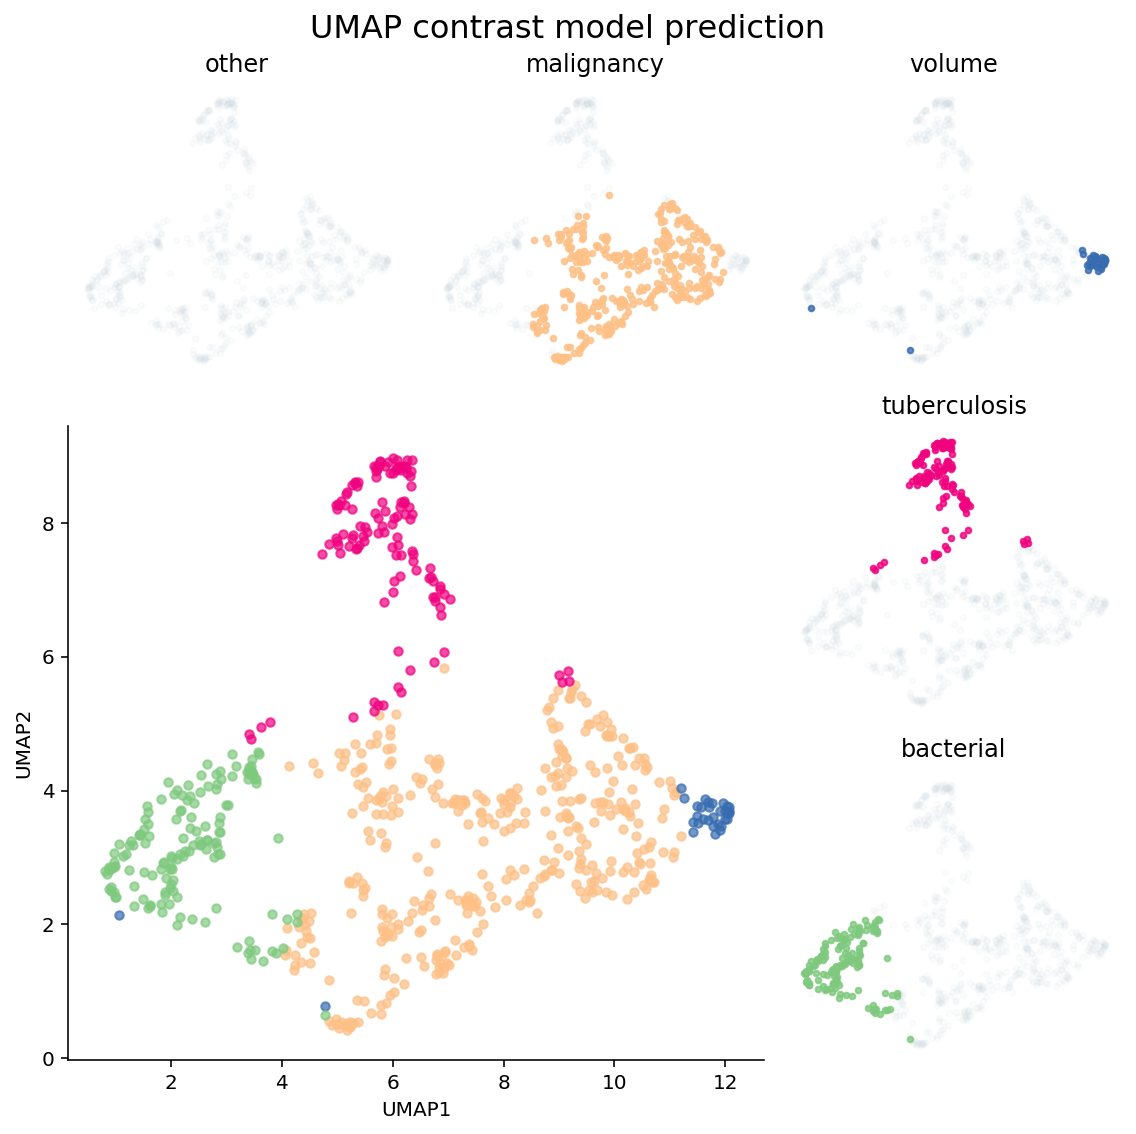

In [363]:
fig5, f5_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f5_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f5_axs[1:, 1]:
    ax.remove()
for ax in f5_axs[1:, 0]:
    ax.remove()
    
axbig = fig5.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig5.tight_layout()
for idx, etiology in enumerate(name):
    axbig.scatter(x=umap_l_predict.loc[umap_l_predict['predict']==etiology,"x"].values,
               y=umap_l_predict.loc[umap_l_predict['predict']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('UMAP1')
    axbig.set_ylabel('UMAP2')
    for j in range(5):
        if j<2:
            f5_axs[0,j].scatter(x=umap_l_predict.loc[umap_l_predict['predict']==etiology,"x"].values,
                                y=umap_l_predict.loc[umap_l_predict['predict']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f5_axs[0,j].set_xticks([])
            f5_axs[0,j].set_yticks([])
            f5_axs[0,j].set_xlabel('')
            f5_axs[0,j].set_ylabel('')
            if idx==j:
                f5_axs[0,j].set_title(f'{etiology}')
            f5_axs[0,j].spines['top'].set_visible(False)
            f5_axs[0,j].spines['right'].set_visible(False)
            f5_axs[0,j].spines['left'].set_visible(False)
            f5_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f5_axs[j-2,2].scatter(x=umap_l_predict.loc[umap_l_predict['predict']==etiology,"x"].values,
                                y=umap_l_predict.loc[umap_l_predict['predict']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f5_axs[j-2,2].set_xticks([])
            f5_axs[j-2,2].set_yticks([])
            f5_axs[j-2,2].set_xlabel('')
            f5_axs[j-2,2].set_ylabel('')
            if idx==j:
                f5_axs[j-2,2].set_title(f'{etiology}')
            f5_axs[j-2,2].spines['left'].set_visible(False)
            f5_axs[j-2,2].spines['right'].set_visible(False)
            f5_axs[j-2,2].spines['bottom'].set_visible(False)
            f5_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
# axbig.spines['bottom'].set_visible(False)
# axbig.spines['left'].set_visible(False)
axbig.spines['top'].set_visible(False)


fig5.tight_layout()
fig5.suptitle("UMAP contrast model prediction", fontsize=16)
fig5.subplots_adjust(top=0.92)
fig5.savefig("./figures/extraval_umap_predict new 300.png", dpi=300)

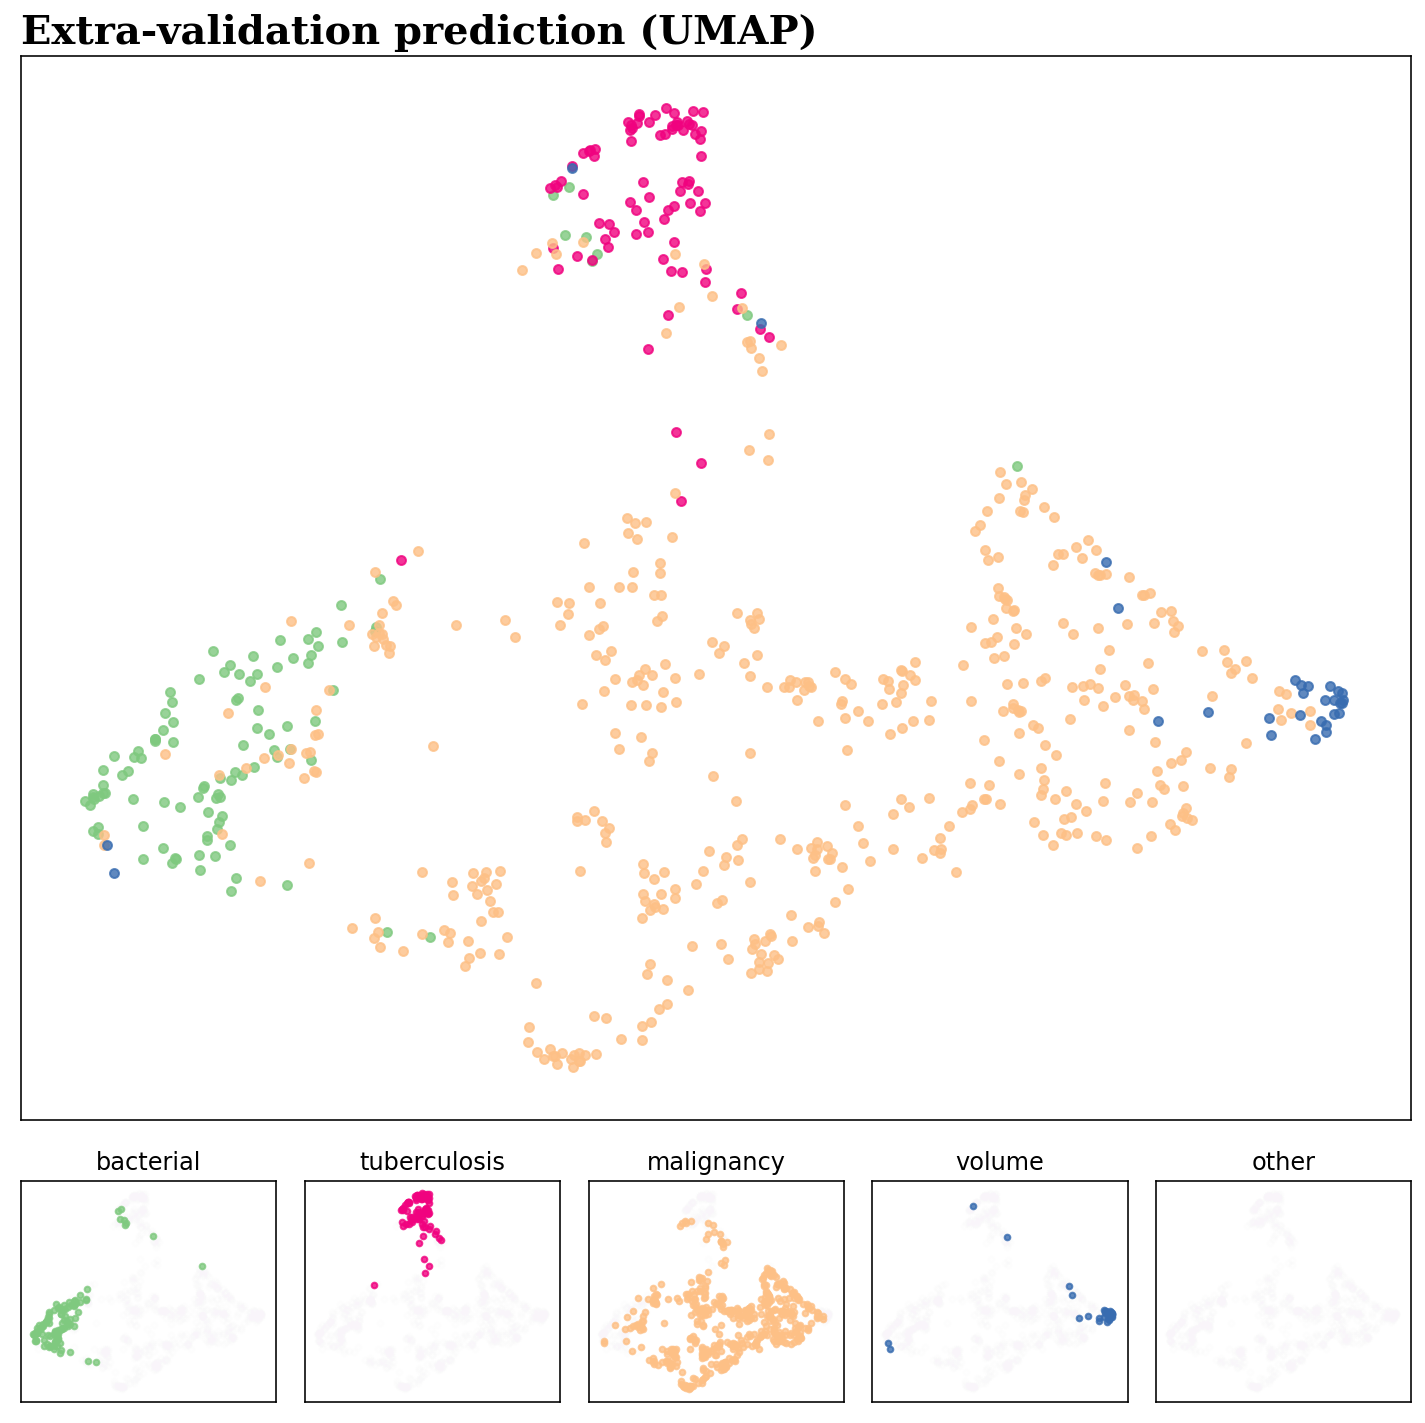

In [364]:
classifier_model =  torch.load('./model_classifier0430/model_[256, 5]_567.pt')

# model = torch.load('./simple_model_1223/512_512_4/model_2_634.pt') """model load """
classifier_model = classifier_model.eval()
p_label = classifier_model(test_X.cuda())
predict = torch.argmax(p_label, axis=1)

umap_l_predict = pd.concat([umap_l,pd.DataFrame(predict.cpu().detach().numpy(),columns=['predict'])], axis=1)
umap_l_predict.predict = umap_l_predict.predict.replace(0,"bacterial").replace(1,"tuberculosis").replace(2,"malignancy").replace(3,"volume").replace(4,"other")

fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(5, 5)
ax = fig.add_subplot(gs[:-1,:])
sub_axes = [None] * 5
for idx in range(5): 
    sub_axes[idx] = fig.add_subplot(gs[-1,idx])

name = ['bacterial','tuberculosis','malignancy','volume','other']
for idx, etiology in enumerate(name):
    ax.scatter(x=umap_l_predict.loc[umap_l_predict['predict']==etiology,"x"].values,
               y=umap_l_predict.loc[umap_l_predict['predict']==etiology,"y"].values,
              s=20, alpha=0.8, color = colorlist[etiology]
              )
    for j in range(5):
        sub_axes[j].scatter(x=umap_l_predict.loc[umap_l_predict['predict']==etiology,"x"].values,
                            y=umap_l_predict.loc[umap_l_predict['predict']==etiology,"y"].values,
                              s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#F9F5FA",
                            zorder=(idx==j)
                           )
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    sub_axes[idx].set_xlabel('')
    sub_axes[idx].set_ylabel('')
    sub_axes[idx].set_title(f'{etiology}')
    sub_axes[idx].spines['right'].set_visible(True)
    sub_axes[idx].spines['top'].set_visible(True)
        
ax.set_title('Extra-validation prediction (UMAP)', fontweight='bold', fontfamily='serif', fontsize=20, loc='left')   

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
fig.tight_layout()
plt.show()
fig.savefig("./figures/extraval_umap_predict[256,5]_.png", dpi=300)

### 작은 model validation

In [19]:
from contrast import small_model

In [28]:
# nnet_model = torch.load('./simple_model_1223/256_256_4/model_[256, 256, 256, 256]_621.pt')
# nnet_model = torch.load('./simple_model_1223/1024_1024_3/model_[1024, 1024, 1024]_629.pt')
nnet_model = torch.load('./simple_model_0502/model_[1024, 1024, 1024, 20]_670.pt')
nnet_model = nnet_model.cuda()
nnet_model.eval()
nnet_pre_label, _nnet_p_label = nnet_model(test_X.cuda())
predict_nnet = torch.argmax(_nnet_p_label, axis=1)

In [30]:
Y_val = torch.tensor(test_Y_data, dtype=torch.long)
one_hot_y = nn.functional.one_hot(Y_val)
soft = nn.Softmax(dim=1)
soft_x_predict_nnet = soft(_nnet_p_label).cpu().detach().numpy()

In [31]:
dr2 = umap.fit_transform(nnet_pre_label.detach().cpu().numpy())

umap_l_nnet = pd.concat([pd.DataFrame(dr2),valid_test_Y], axis=1)
umap_l_nnet = umap_l_nnet.rename(columns={0:"x", 1:"y"})



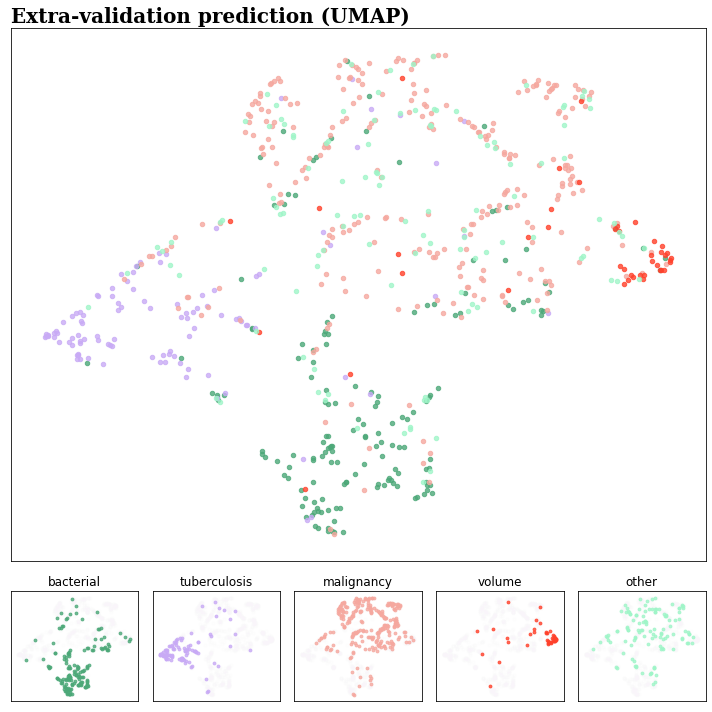

In [32]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(5, 5)
ax = fig.add_subplot(gs[:-1,:])
sub_axes = [None] * 5
for idx in range(5): 
    sub_axes[idx] = fig.add_subplot(gs[-1,idx])

name = ['bacterial','tuberculosis','malignancy','volume','other']
for idx, etiology in enumerate(name):
    ax.scatter(x=umap_l_nnet.loc[umap_l_nnet['final_label']==etiology,"x"].values,
               y=umap_l_nnet.loc[umap_l_nnet['final_label']==etiology,"y"].values,
              s=20, alpha=0.8, color = colorlist[etiology]
              )
    for j in range(5):
        sub_axes[j].scatter(x=umap_l_nnet.loc[umap_l_nnet['final_label']==etiology,"x"].values,
                            y=umap_l_nnet.loc[umap_l_nnet['final_label']==etiology,"y"].values,
                              s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#F9F5FA",
                            zorder=(idx==j)
                           )
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    sub_axes[idx].set_xlabel('')
    sub_axes[idx].set_ylabel('')
    sub_axes[idx].set_title(f'{etiology}')
    sub_axes[idx].spines['right'].set_visible(True)
    sub_axes[idx].spines['top'].set_visible(True)
        
ax.set_title('Extra-validation prediction (UMAP)', fontweight='bold', fontfamily='serif', fontsize=20, loc='left')   

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
fig.tight_layout()
plt.show()
fig.savefig("./figures/extraval_umap_nnet.png", dpi=300)